In [361]:
import awkward
import uproot
import bz2
import pyhepmc
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import fastjet
import vector
import awkward

import sys
sys.path.append("../../mlpf/")

import jet_utils

In [362]:
# static const int BITCreatedInSimulation = 30;\n
# static const int BITBackscatter = 29 ;\n
# static const int BITVertexIsNotEndpointOfParent = 28 ;  \n
# static const int BITDecayedInTracker = 27 ; \n
# static const int BITDecayedInCalorimeter = 26 ;   \n
# static const int BITLeftDetector = 25 ;     \n
# static const int BITStopped = 24 ;    \n
# static const int BITOverlay = 23 ;    \n
# virtual bool 	isCreatedInSimulation () const =0
#  	True if the particle has been created by the simulation program (rather than the generator). More...
 
# virtual bool 	isBackscatter () const =0
#  	True if the particle was created by the simulator as a result of an interaction or decay in non-tracking region, e.g. More...
 
# virtual bool 	vertexIsNotEndpointOfParent () const =0
#  	True if the particle was created as a result of a continuous process where the parent particle continues, i.e. More...
 
# virtual bool 	isDecayedInTracker () const =0
#  	True if the particle decayed or interacted in a tracking region. More...
 
# virtual bool 	isDecayedInCalorimeter () const =0
#  	True if the particle decayed or interacted (non-continuous interaction, particle terminated) in non-tracking region. More...
 
# virtual bool 	hasLeftDetector () const =0
#  	True if the particle left the world volume undecayed. More...
 
# virtual bool 	isStopped () const =0
#  	True if the particle lost all kinetic energy inside the world volume and did not decay. More...
 
# virtual bool 	isOverlay () const =0
#  	True if the particle has been overlayed by the simulation (or digitization) program. More...

def check_bit(bitfield, bit):
    return np.bitwise_and(bitfield, np.left_shift(1, bit))!=0

In [363]:
jetdef = fastjet.JetDefinition(fastjet.ee_genkt_algorithm, 0.4, -1.0)
min_pt = 5

def load_hepmc(hepmc_file_path):
    events = []
    # with pyhepmc.open(bz2.BZ2File(hepmc_file_path, "rb")) as f:
    with pyhepmc.open(hepmc_file_path) as f:
        for event in f:
            parts = [p for p in event.particles if p.status == 1]
            parts = {
                "MCParticles.momentum.x": [p.momentum.x for p in parts],
                "MCParticles.momentum.y": [p.momentum.y for p in parts],
                "MCParticles.momentum.z": [p.momentum.z for p in parts],
                "MCParticles.mass": [p.momentum.m() for p in parts],
                "MCParticles.PDG": [p.pid for p in parts],
                "MCParticles.generatorStatus": [p.status for p in parts],
                "MCParticles.num_children": [len(p.children) for p in parts],
            }
            events.append(parts)
    events = awkward.from_iter(events)
    return events

def to_p4(invec):
    vec = vector.awk(
        awkward.zip(
            {   
                "px": invec.px,
                "py": invec.py,
                "pz": invec.pz,
                "energy": invec.E,
            }
        )
    )
    return vec

def to_p4_sph(invec):
    vec = vector.awk(
        awkward.zip(
            {   
                "pt": invec.pt,
                "eta": invec.eta,
                "phi": invec.phi,
                "energy": invec.E,
            }
        )
    )
    return vec
def reconstruct_jets(particles):
    vec_ptcls = vector.awk(
        awkward.zip(
            {   
                "px": particles["MCParticles.momentum.x"],
                "py": particles["MCParticles.momentum.y"],
                "pz": particles["MCParticles.momentum.z"],
                "mass": particles["MCParticles.mass"],
            }
        )
    )
    
    cluster = fastjet.ClusterSequence(vec_ptcls.to_xyzt(), jetdef)
    return cluster.inclusive_jets(min_pt=min_pt)

In [364]:
fi = uproot.open("/scratch/local/joosep/p8_ee_tt_ecm380_/out_sim_edm4hep.root")
tt = fi["events"]

In [365]:
mc_edm4hep = tt.arrays([
    "MCParticles.PDG",
    "MCParticles.momentum.x",
    "MCParticles.momentum.y",
    "MCParticles.momentum.z",
    "MCParticles.momentumAtEndpoint.x",
    "MCParticles.momentumAtEndpoint.y",
    "MCParticles.momentumAtEndpoint.z",
    "MCParticles.mass",
    "MCParticles.charge",
    "MCParticles.generatorStatus",
    "MCParticles.simulatorStatus",
    "MCParticles.parents_begin",
    "MCParticles.parents_end",
    "MCParticles.daughters_begin",
    "MCParticles.daughters_end",
])

vec_ptcls = vector.awk(
    awkward.zip(
        {   
            "px": mc_edm4hep["MCParticles.momentum.x"],
            "py": mc_edm4hep["MCParticles.momentum.y"],
            "pz": mc_edm4hep["MCParticles.momentum.z"],
            "mass": mc_edm4hep["MCParticles.mass"],
        }
    )
)

mc_edm4hep["MCParticles.pt"] = vec_ptcls.pt
mc_edm4hep["MCParticles.eta"] = vec_ptcls.eta
mc_edm4hep["MCParticles.phi"] = vec_ptcls.phi

mc_edm4hep["MCParticles.BitStopped"] = check_bit(mc_edm4hep["MCParticles.simulatorStatus"], 24)
mc_edm4hep["MCParticles.BitLeftDetector"] = check_bit(mc_edm4hep["MCParticles.simulatorStatus"], 25)
mc_edm4hep["MCParticles.BitDecayedInCalorimeter"] = check_bit(mc_edm4hep["MCParticles.simulatorStatus"], 26)
mc_edm4hep["MCParticles.BitDecayedInTracker"] = check_bit(mc_edm4hep["MCParticles.simulatorStatus"], 27)
mc_edm4hep["MCParticles.BitVertexIsNotEndpointOfParent"] = check_bit(mc_edm4hep["MCParticles.simulatorStatus"], 28)
mc_edm4hep["MCParticles.BitBackscatter"] = check_bit(mc_edm4hep["MCParticles.simulatorStatus"], 29)


In [366]:
mc_st0 = mc_edm4hep[mc_edm4hep["MCParticles.generatorStatus"]==0]
mc_st1 = mc_edm4hep[mc_edm4hep["MCParticles.generatorStatus"]==1]
mc_st2 = mc_edm4hep[mc_edm4hep["MCParticles.generatorStatus"]==2]

In [369]:
np.sum(mc_st1["MCParticles.PDG"]==5)

0

In [360]:
mc_st0[mc_st0["MCParticles.pt"]>10][90][['MCParticles.PDG', 'MCParticles.pt', 'MCParticles.eta', 'MCParticles.phi']]

<Record {'MCParticles.PDG': [...], ...} type='{"MCParticles.PDG": var * int...'>

In [359]:
mc_st1[mc_st1["MCParticles.pt"]>10][90][['MCParticles.PDG', 'MCParticles.pt', 'MCParticles.eta', 'MCParticles.phi']]

<Record {'MCParticles.PDG': [...], ...} type='{"MCParticles.PDG": var * int...'>

In [205]:
jets_mc = to_p4_sph(reconstruct_jets(mc_st1))

In [206]:
hepmc = load_hepmc("/home/joosep/p8_ee_tt_ecm380_/out.hepmc")
jets_hepmc = to_p4_sph(reconstruct_jets(hepmc))

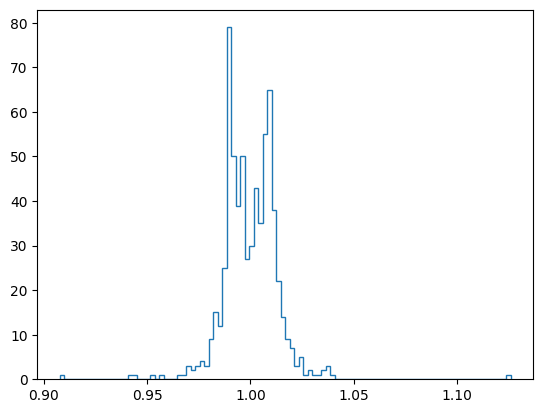

In [207]:
ret = jet_utils.match_jets(jets_mc, jets_hepmc, 0.1)
j1_idx = awkward.from_iter(ret[0])
j2_idx = awkward.from_iter(ret[1])
gj_pt = awkward.flatten(jets_mc[j1_idx].pt)
tj_pt = awkward.flatten(jets_hepmc[j2_idx].pt)
plt.hist((tj_pt/gj_pt), bins=100, histtype="step", label="target/truth");

In [208]:
np.min(awkward.flatten(hepmc["MCParticles.mass"]) - awkward.flatten(mc_st1["MCParticles.mass"]))

-2.132480599880018e-06

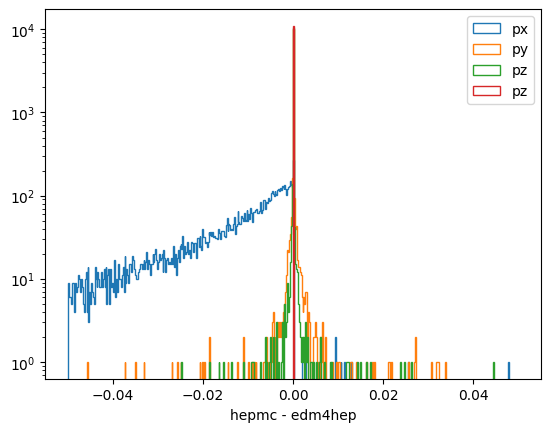

In [209]:
b = np.linspace(-0.05, 0.05, 500)
plt.hist(
    awkward.flatten(hepmc["MCParticles.momentum.x"]) - awkward.flatten(mc_st1["MCParticles.momentum.x"]),
    bins=b, histtype="step", lw=1, label="px"
);
plt.hist(
    awkward.flatten(hepmc["MCParticles.momentum.y"]) - awkward.flatten(mc_st1["MCParticles.momentum.y"]),
    bins=b, histtype="step", lw=1, label="py"
);

plt.hist(
    awkward.flatten(hepmc["MCParticles.momentum.z"]) - awkward.flatten(mc_st1["MCParticles.momentum.z"]),
    bins=b, histtype="step", lw=1, label="pz"
);

plt.hist(
    awkward.flatten(hepmc["MCParticles.mass"]) - awkward.flatten(mc_st1["MCParticles.mass"]),
    bins=b, histtype="step", lw=1, label="pz"
);

plt.xlabel("hepmc - edm4hep")
plt.yscale("log")
plt.legend()